In [1]:
import time
import random
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical

from omegaconf import OmegaConf

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
import gymnasium as gym
from gymnasium.experimental.wrappers import RecordVideoV0 as RecordVideo # warppers for making game video


# Requirements
- Selecting environments
- Implementing PPO

# 1. Select your environment

In [3]:
# select your environment from the list
"""
environments list  
classic control env_id list:  ["Acrobot-v1", "MountainCar-v0", "Pendulum-v1"]  
box2d env_id list:            ["LunarLander-v2", "BipedalWalker-v3"]  
mujoco env_id list:           ["Swimmer-v4" , "Reacher-v4", "Hopper-v4", "Walker2d-v4", "Ant-v4", "HalfCheetah-v4", "HumanoidStandup-v4"]  
atari env_id list:            ["BreakoutNoFrameskip-v4", "MsPacmanNoFrameskip-v4", "PongNoFrameskip-v4"] (optional. not recommended for no gpu device)
"""

env_id = "HumanoidStandup-v4" 

In [4]:
mujoco_env_id = ["Swimmer-v4" , "Reacher-v4", "Hopper-v4", "Walker2d-v4", "Ant-v4", "HalfCheetah-v4", "HumanoidStandup-v4"]

### 1.1 experiment config, path config

### Try to change the experiment configurations except `max_episode_steps`.

In [5]:
exp_config_dict = {
    "seed": 0, # environment seed
    "num_envs": 1, # the number of environments for parallel training
    "num_eval": 10, # the number of evaluations
    "max_episode_steps": 2048, # the maximum number of episode steps. Used in mujoco environments ! Don't change this value
    "num_rollout_steps": 2048, # the number of policy rollout steps, default 128 = num_steps
    "num_minibatches": 32, # The number of minibatches per 1 epoch (Not mibi batch size) default 4
    "total_timesteps": 5000000, # total number of frames
    "print_interval": 100, # print iverval of episodic return
    "early_stop_wating_steps": 5000, # early stopping steps
}
exp_config = OmegaConf.create(exp_config_dict)

path_config = OmegaConf.create({
  "logs": Path("./exp12/runs"),
  "videos":Path("./exp12/videos"),
  "checkpoints": Path("./exp12/checkpoints"),
})


### 1.2 make_env function
For vectorized environments, we need a callable make_env function.

In [6]:
def make_env(env_id, exp_config, path_config: OmegaConf, gamma=0.99, evaluation=False, idx=0):
    video_path = Path(path_config.videos)
    def thunk():
        env = gym.make(env_id, render_mode="rgb_array")
        if evaluation:
            test_path = Path(f"{env_id}/test")
            video_save_path = str(video_path / test_path)
        else:
            train_path = Path(f"{env_id}/train")
            video_save_path = str(video_path / train_path)
        if idx==0:
            env = RecordVideo(env, video_save_path, disable_logger=True)
        env = gym.wrappers.FlattenObservation(env)  # deal with dm_control's Dict observation space
        env = gym.wrappers.RecordEpisodeStatistics(env)
        if env_id in mujoco_env_id:
            env = gym.wrappers.TimeLimit(env, exp_config.max_episode_steps)
        env = gym.wrappers.ClipAction(env)
        env = gym.wrappers.NormalizeObservation(env)
        env = gym.wrappers.TransformObservation(env, lambda obs: np.clip(obs, -10, 10))
        env = gym.wrappers.NormalizeReward(env, gamma=gamma)
        env = gym.wrappers.TransformReward(env, lambda reward: np.clip(reward, -10, 10))
        return env
    return thunk

In [7]:
make_env(env_id, exp_config, path_config) # the return of make_env is callable function

<function __main__.make_env.<locals>.thunk()>

In [8]:
env = make_env(env_id, exp_config, path_config)() # <- Note that () is call action

In [9]:
# Vectorized environments for fast training
# https://gymnasium.farama.org/api/vector/
envs = gym.vector.SyncVectorEnv([make_env(env_id, exp_config, path_config, evaluation=False, idx=idx)
                                for idx in range(exp_config.num_envs)])


c:\Users\user\anaconda3\envs\rl\Lib\site-packages\gymnasium\experimental\wrappers\rendering.py:169: UserWarning: WARN: Overwriting existing videos at d:\DeepLearning\RL_Humanoid\exp12\videos\HumanoidStandup-v4\train folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


### Note that whether the environment is discrete or continuous
`gymnasium.spaces.Box`: continuous space   
`gynmasium.spaces.Discrete`: discrete space


In [10]:
print(env.observation_space)
print(env.action_space)

Box(-inf, inf, (376,), float64)
Box(-0.4, 0.4, (17,), float32)


# 2. make configurations
- environment
- ppo hyperparameters


### 2.1 make environment config
This configuration store the information of environment to build the neural network

In [11]:
from gymnasium.spaces import Discrete, Box

def make_env_config(envs):
    env = envs.envs[0] 
    print(env.observation_space)
    print(env.action_space)
    
    # * observation information
    if isinstance(env.observation_space, Discrete): # if observation_space is discrete
        state_dim = env.observation_space.n
    
    else:  # if observation_space is continuous
        if len(env.observation_space.shape) > 1: # Atari visual observation case
            state_dim = env.observation_space.shape
        else: # 1D vector observation case (classic control, box2d, mujoco)
            state_dim = env.observation_space.shape[0]
    
    # * action_space information
    num_discretes = 0
    if isinstance(env.action_space, Box):
        action_dim = env.action_space.shape[0]
        is_continuous = True
    elif isinstance(env.action_space, Discrete):
        action_dim = 1
        num_discretes = env.action_space.n
        is_continuous = False
    env_config = OmegaConf.create({"state_dim": state_dim,
                    "action_dim": int(action_dim),
                    "hidden_dim1": 128,
                    "hidden_dim2": 64,
                    "hidden_dim3": 32,
                    "num_discretes": int(num_discretes),
                    "is_continuous": is_continuous,
                    "rpo_alpha": 0.5}) # hyperparameter, 0.1, 0.5, 1, 3 are best
  
    return env_config


In [12]:
env_config = make_env_config(envs)
env_config

Box(-inf, inf, (376,), float64)
Box(-0.4, 0.4, (17,), float32)


{'state_dim': 376, 'action_dim': 17, 'hidden_dim1': 128, 'hidden_dim2': 64, 'hidden_dim3': 32, 'num_discretes': 0, 'is_continuous': True, 'rpo_alpha': 0.5}

### 2.2 ppo config
This configuration store the information of hyperparameters for training

### Try to change the ppo configurations depending on selected environment

In [13]:
ppo_config_dict = {
    "anneal_lr": True,
    "update_epochs": 10, # The number of iteractions of ppo training
    "minibatch_size": 64,  # default 32
    "lr": 2e-5,
    "max_grad_norm": 0.5, # default 2.0 
    "norm_adv": True,
    "clip_coef": 0.2,
    "ent_coef": 0.0001, # default 0.01
    "vf_coef": 0.5,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "batch_size": 2048,
    }
ppo_config = OmegaConf.create(ppo_config_dict)
print(ppo_config)
print(ppo_config.minibatch_size)
print(ppo_config.batch_size)


{'anneal_lr': True, 'update_epochs': 10, 'minibatch_size': 64, 'lr': 2e-05, 'max_grad_norm': 0.5, 'norm_adv': True, 'clip_coef': 0.2, 'ent_coef': 0.0001, 'vf_coef': 0.5, 'gamma': 0.99, 'gae_lambda': 0.95, 'batch_size': 2048}
64
2048


# 3. Implementing PPO

You should do the following to implement PPO.
- Complete the ActorCritic class
- Implement the generalized advatage calculation part
- Implement the PPO loss and Value loss calculation part

### 3.1 ActorCritic Class

### You can create a neural network as you want to implement it.

In [14]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class ActorCritic(nn.Module):
    def __init__(self, env_config):
        super().__init__()
        self.state_dim = env_config["state_dim"]
        self.hidden_dim1 = env_config["hidden_dim1"]
        self.hidden_dim2 = env_config["hidden_dim2"]
        self.hidden_dim3 = env_config["hidden_dim3"]
        self.action_dim = env_config["action_dim"]
        self.num_discretes = env_config["num_discretes"]
        self.is_continuous = env_config["is_continuous"]
        self.rpo_alpha = env_config["rpo_alpha"]
        self.action_loss = nn.MSELoss()
        
        ###################### Implement here : 1. Neural Network ########################
        self.critic = nn.Sequential(
            layer_init(nn.Linear(self.state_dim, self.hidden_dim1)),
            nn.Tanh(),
            layer_init(nn.Linear(self.hidden_dim1, self.hidden_dim2)),
            nn.Tanh(),
            layer_init(nn.Linear(self.hidden_dim2, self.hidden_dim3)),
            nn.Tanh(),
            layer_init(nn.Linear(self.hidden_dim3, 1), std=0.01)
        )
        if self.is_continuous:
            self.actor_mean = nn.Sequential(
                layer_init(nn.Linear(self.state_dim, self.hidden_dim1)),
                nn.Tanh(),
                layer_init(nn.Linear(self.hidden_dim1, self.hidden_dim2)),
                nn.Tanh(),
                layer_init(nn.Linear(self.hidden_dim2, self.hidden_dim3)),
                nn.Tanh(),
                layer_init(nn.Linear(self.hidden_dim3, self.action_dim), std=0.01)
            )
            self.actor_logstd = nn.Parameter(torch.zeros(1, self.action_dim))
        
        else:
            self.actor_logit = 0 # Not necessary
            
    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        ###################### Implement here : policy distribution ########################
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        action_mean = self.actor_mean(x)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            action = probs.sample()
        else: # new to RPO
            # sample again to add some stochasticity, for update the policy
            z = torch.FloatTensor(action_mean.shape).uniform_(-self.rpo_alpha, self.rpo_alpha).to(device)
            action_mean = action_mean + z
            probs = Normal(action_mean, action_std)
        
        ###################### Symmetric action loss ########################
        sym_act_loss_1 = self.action_loss(probs.log_prob(action)[:, 3:7], probs.log_prob(action)[:, 7:11])
        sym_act_loss_2 = self.action_loss(probs.log_prob(action)[:, 11:14], probs.log_prob(action)[:, 14:17])
        sym_act_loss = 0.5 * (sym_act_loss_1 + sym_act_loss_2)
        
        return action, probs.log_prob(action).sum(1), probs.entropy().sum(1), self.critic(x), sym_act_loss
        
        
def save_model(env_id, path_cfg, actor_critic, update):
    ckpt_path = Path(path_cfg.checkpoints) / Path(f"{env_id}")
    if not ckpt_path.exists():
        ckpt_path.mkdir()
    model_name = Path(f"PPO_{update}.pt")
    model_path = ckpt_path / model_name
    torch.save(actor_critic.state_dict(), str(model_path))
    print(f"model saved to {model_path}")

In [15]:
from dataclasses import dataclass
from typing import List

@dataclass
class GlobalLogger:
    global_steps: List
    save_update_steps: List
    episodic_return_steps: List
    train_episodic_return: List 
    test_episodic_return: List 
    policy_loss: List
    value_loss: List
    entropy_loss: List

## 3.2 train 

### Implement the GAE calculation part and ppo loss, value loss part by referring the pictures.

### GAE: https://arxiv.org/abs/1506.02438


### PPO: https://arxiv.org/abs/1707.06347



### GAE calculation

![](GAE_calculation.png)

#### PPO Clipped loss

![](PPO_loss.png)

### You can refer to any open source code and complete it. 
GAE references:  
- https://towardsdatascience.com/generalized-advantage-estimate-maths-and-code-b5d5bd3ce737  
- https://danieltakeshi.github.io/2017/04/02/notes-on-the-generalized-advantage-estimation-paper/  

PPO references:  
- https://spinningup.openai.com/en/latest/algorithms/ppo.html  

In [16]:
from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output

global_logger = GlobalLogger(
                            global_steps = [],
                            save_update_steps = [],
                            episodic_return_steps = [],
                            train_episodic_return=[],
                            test_episodic_return=[],
                            policy_loss=[],
                            value_loss=[],
                            entropy_loss=[]
                            )

# Set minibatch_size 
# tensorboard writer, global_recorder
log_path = str(Path(path_config.logs) / Path(env_id))
writer = SummaryWriter(log_path)
global_logger.log_path = log_path

structure_dict = {"structrue": 'state-128-64-32-action, ent_coef=0.0001, rpo_coef=0.5, action_coef=0.02, lr=2e-5'}
# save configs
class Dict2Class(object):
    def __init__(self, my_dict):
        for key  in my_dict:
            setattr(self, key, my_dict[key])
configs = Dict2Class(exp_config_dict|ppo_config_dict|structure_dict)
writer.add_text(
        "hyperparameters",
        "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(configs).items()])),
    )

# Managing seed for reproducible experiments
random.seed(exp_config.seed)
np.random.seed(exp_config.seed)
torch.manual_seed(exp_config.seed)
torch.backends.cudnn.deterministic = True

# Set device and make environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

envs = gym.vector.SyncVectorEnv(
    [make_env(env_id, exp_config, path_config, evaluation=False, idx=idx) for idx in range(exp_config.num_envs)]
)

# Initialize agent and optimizer
agent = ActorCritic(env_config).to(device)
optimizer = optim.Adam(agent.parameters(), lr=ppo_config.lr, eps=1e-5)

# ALGO Logic: On Policy Storage setup
obs = torch.zeros((exp_config.num_rollout_steps, exp_config.num_envs) + envs.single_observation_space.shape).to(device)
actions = torch.zeros((exp_config.num_rollout_steps, exp_config.num_envs) + envs.single_action_space.shape).to(device)
logprobs = torch.zeros((exp_config.num_rollout_steps, exp_config.num_envs)).to(device)
rewards = torch.zeros((exp_config.num_rollout_steps, exp_config.num_envs)).to(device)
dones = torch.zeros((exp_config.num_rollout_steps, exp_config.num_envs)).to(device)
values = torch.zeros((exp_config.num_rollout_steps, exp_config.num_envs)).to(device)


global_step = 0
start_time = time.time()
next_obs, _ = envs.reset(seed=exp_config.seed)
next_obs = torch.Tensor(next_obs).to(device)
next_done = torch.zeros(exp_config.num_envs).to(device)
num_updates = exp_config.total_timesteps // exp_config.num_rollout_steps # number of epochs

save_positions = np.arange(0, num_updates//10 + num_updates, num_updates//10)

for update in range(1, num_updates + 1):
    # Annealing the rate if instructed to do so.
    if ppo_config.anneal_lr:
        frac = 1.0 - (update - 1.0) / num_updates
        lrnow = frac * ppo_config.lr
        optimizer.param_groups[0]["lr"] = lrnow

    # ! rollout multiple environments
    for step in range(0, exp_config.num_rollout_steps):
        global_step += 1 * exp_config.num_envs
        obs[step] = next_obs
        dones[step] = next_done

        # ALGO LOGIC: action logic
        with torch.no_grad():
            action, logprob, _, value, _ = agent.get_action_and_value(next_obs)
            values[step] = value.flatten()
        actions[step] = action
        logprobs[step] = logprob

        next_obs, reward, terminated, truncated, infos = envs.step(action.cpu().detach().numpy())
        done = np.logical_or(terminated, truncated)
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(done).to(device)

        # Only print when at least 1 env is done
        if "final_info" not in infos:
            continue
        for info in infos["final_info"]:
            # Skip the envs that are not done
            if info is None:
                continue
            print(f"num_updates: {update}/{num_updates}, global_step={global_step}, episodic_return={info['episode']['r']}")
            writer.add_scalar("charts/episodic_return", info["episode"]["r"], global_step)
            writer.add_scalar("charts/episodic_length", info["episode"]["l"], global_step)
            global_logger.train_episodic_return.append(info["episode"]["r"])
            global_logger.episodic_return_steps.append(global_step)
            
    # Save model
    if update in save_positions:
        global_logger.save_update_steps.append(update)
        save_model(env_id, path_config, agent, update)

    global_logger.global_steps.append(global_step)
        
    # ! bootstrap value if not done
    ###################### Implement here : 2. Generalized Advantage Estimation ######################## 
    # GAE part. Refer the GAE calculation picture
       
    with torch.no_grad():
        next_value = agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)
        last_gae_lambda = 0
        for t in reversed(range(exp_config.num_rollout_steps)):
            if t == exp_config.num_rollout_steps - 1:
                done_mask = 1.0 - next_done
                nextvalues = next_value
            else:
                done_mask = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]
            delta = rewards[t] + ppo_config.gamma * nextvalues * done_mask - values[t]
            advantages[t] = last_gae_lambda = delta + ppo_config.gamma * ppo_config.gae_lambda * done_mask * last_gae_lambda
        
        returns = advantages + values

    b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # ! Optimizing the policy and value network
    agent.train()
    batch_size = exp_config.num_rollout_steps * exp_config.num_envs
    mb_size = ppo_config.minibatch_size
    b_inds = np.arange(batch_size) # batch_size = num_rollout_steps
    for epoch in range(ppo_config.update_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, batch_size, mb_size):
            end = start + mb_size
            mb_inds = b_inds[start:end]

            _, newlogprob, entropy, newvalue, sym_act_loss = agent.get_action_and_value(b_obs[mb_inds], b_actions[mb_inds])
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            mb_advantages = b_advantages[mb_inds]
            if ppo_config.norm_adv:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            ###################### Implement here : 3. PPO Loss, Value Loss ########################    
            # Be careful about pytorch automatic broadcasting.
            # Policy loss part. Refer the PPO clip loss picture
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - ppo_config.clip_coef, 1 + ppo_config.clip_coef)
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = newvalue.view(-1)
            v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
            v_clipped = b_values[mb_inds] + torch.clamp(
                newvalue - b_values[mb_inds],
                -ppo_config.clip_coef,
                ppo_config.clip_coef,
            )
            v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
            v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
            v_loss = 0.5 * v_loss_max.mean()

            entropy_loss = entropy.mean()

            ###################### Implement here : 4. Total Loss ########################    
            # implement the total loss value by using the coefficients in ppo_config
            total_loss = pg_loss + - ppo_config.ent_coef * entropy_loss + v_loss * ppo_config.vf_coef + 0.02*sym_act_loss 
            optimizer.zero_grad()
            total_loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), ppo_config.max_grad_norm)
            optimizer.step()

    writer.add_scalar("charts/learning_rate", optimizer.param_groups[0]["lr"], global_step)
    writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
    writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
    writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
    writer.add_scalar("losses/symmetry_action_loss", sym_act_loss.item(), global_step)
    writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)
    global_logger.value_loss.append(v_loss.item())
    global_logger.policy_loss.append(pg_loss.item())
    # global_logger.entropy_loss.append(entropy_loss.item())
    
    if update % 8 == 0:
        clear_output()
        
envs.close()
writer.close()
print("Training is finished...")
    


num_updates: 241/2441, global_step=492000, episodic_return=[97672.89]
num_updates: 241/2441, global_step=493000, episodic_return=[73439.3]
num_updates: 242/2441, global_step=494000, episodic_return=[92441.48]
num_updates: 242/2441, global_step=495000, episodic_return=[78384.914]
num_updates: 243/2441, global_step=496000, episodic_return=[86083.12]
num_updates: 243/2441, global_step=497000, episodic_return=[61479.414]
num_updates: 244/2441, global_step=498000, episodic_return=[55988.227]
num_updates: 244/2441, global_step=499000, episodic_return=[78079.79]


FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'exp12\\checkpoints\\HumanoidStandup-v4'

In [ ]:
save_model(env_id, path_config, agent, update)

model saved to exp12\checkpoints\HumanoidStandup-v4\PPO_2441.pt


# Visualization of results

In [ ]:
x = np.array(global_logger.episodic_return_steps)
y = np.array(global_logger.train_episodic_return).squeeze(1)
print(x.shape)
print(y.shape)

(4999,)
(4999,)


figure is saved to exp12\runs\HumanoidStandup-v4\train_episodic_return.jpg


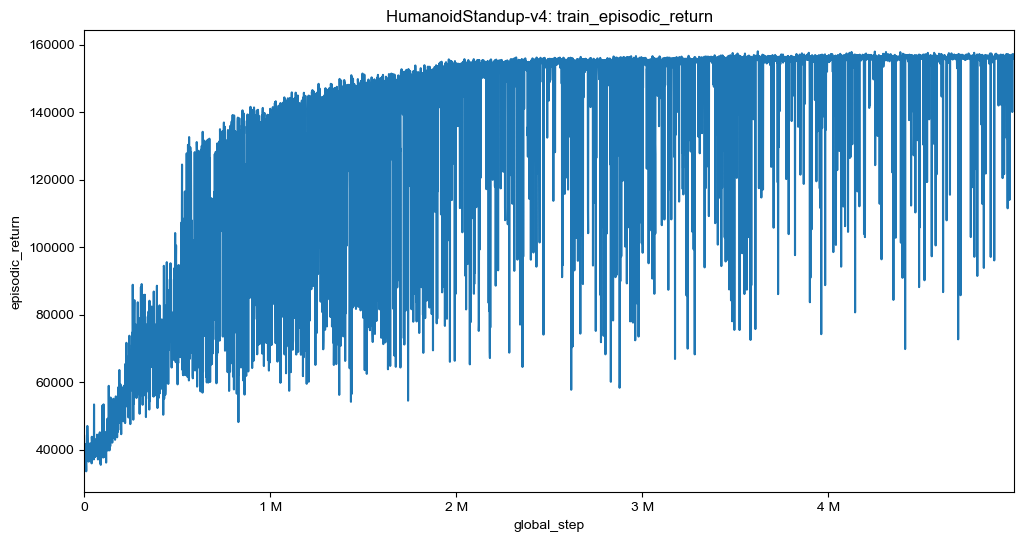

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.set_style('darkgrid')
sns.set_context("poster")
sns.set(font_scale=1)
g = sns.lineplot(x=x, y=y).set(title=f'{env_id}: train_episodic_return')
global_logger.global_steps
ax.set(xlim = (0,global_logger.global_steps[-1]))
ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.set(xlabel='global_step', ylabel='episodic_return')
save_path = Path(global_logger.log_path)
file_name =  Path("train_episodic_return.jpg")
file_path = save_path / file_name
print(f"figure is saved to {str(file_path)}")
plt.savefig(str(file_path), dpi = 200)

In [ ]:
def evaluate(env_id, exp_config, path_config, env_config, ppo_config, global_logger):
    envs = gym.vector.SyncVectorEnv(
             [make_env(env_id, exp_config, path_config, evaluation=True, idx=0)]
            )
    device = torch.device("cpu")
    agent = ActorCritic(env_config).to(device)
    ckpt_path = Path(path_config.checkpoints) / Path(env_id)
    file_name = Path(f"PPO_{update}.pt")
    file_path = str(ckpt_path / file_name)
    agent.load_state_dict(torch.load(file_path, map_location=device))
    agent.eval()
    print("Loading model is successful")
    
    next_obs, _ = envs.reset()
    next_obs = torch.Tensor(next_obs).to(device)
    next_done = torch.zeros(1).to(device)
    episodic_returns = []
    while len(episodic_returns) < exp_config.num_eval:
        with torch.no_grad():
            action, logprob, _, value, _ = agent.get_action_and_value(next_obs)
        next_obs, reward, terminated, truncated, infos = envs.step(action.cpu().numpy())
        done = np.logical_or(terminated, truncated)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(done).to(device)
        # Only print when at least 1 env is done
        if "final_info" not in infos:
            continue
        for info in infos["final_info"]:
            # Skip the envs that are not done
            if info is None:
                continue
            print(f"test_episodic_return={info['episode']['r']}")
            episodic_returns.append(info['episode']['r'])
    global_logger.test_episodic_return = episodic_returns

In [ ]:
evaluate(env_id, exp_config, path_config, env_config, ppo_config, global_logger)

Loading model is successful
test_episodic_return=[53997.52]
test_episodic_return=[133329.72]
test_episodic_return=[97242.24]
test_episodic_return=[117630.164]
test_episodic_return=[123396.48]
test_episodic_return=[100964.56]
test_episodic_return=[107862.375]
test_episodic_return=[65389.52]
test_episodic_return=[99452.41]
test_episodic_return=[79825.086]


In [ ]:
y = np.array(global_logger.test_episodic_return)
y = y.squeeze(1)
y

array([ 53997.52 , 133329.72 ,  97242.24 , 117630.164, 123396.48 ,
       100964.56 , 107862.375,  65389.52 ,  99452.41 ,  79825.086],
      dtype=float32)

In [ ]:
y.mean()

97909.01

figure is saved to exp12\runs\HumanoidStandup-v4\test_episodic_return.jpg


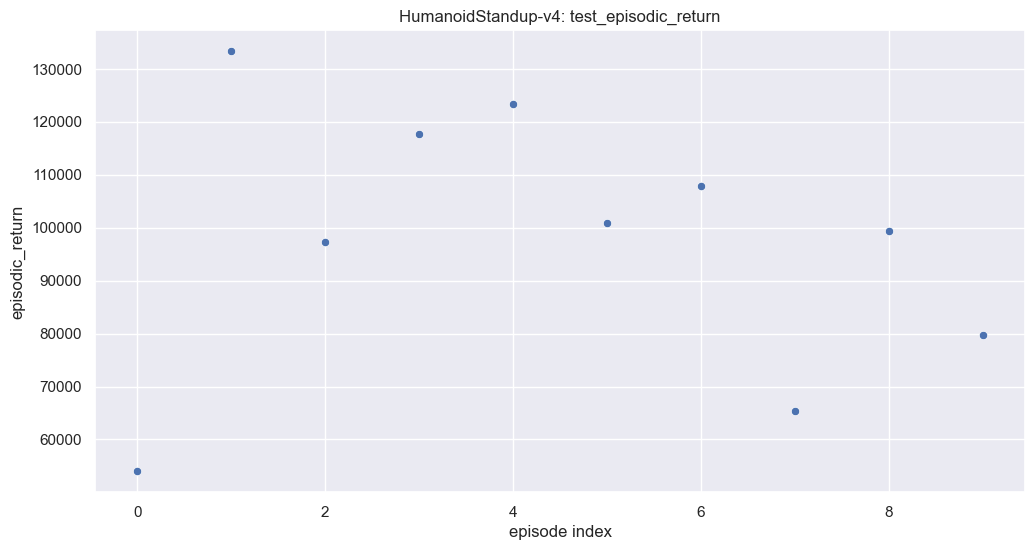

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(xlabel='episode index', ylabel='episodic_return')
sns.set_style('darkgrid')
sns.set_context("poster")
sns.set(font_scale=1)
g = sns.scatterplot(x=range(len(y)), y=y).set(title=f'{env_id}: test_episodic_return')
save_path = Path(global_logger.log_path)
file_name =  Path("test_episodic_return.jpg")
file_path = save_path / file_name
print(f"figure is saved to {str(file_path)}")
plt.savefig(str(file_path), dpi = 200)